In [1]:
import numpy as np
from typing import Callable, Dict, List, Tuple

Linear regression from scratch using numpy

In [2]:
def forward_linear_regression(X_batch: np.ndarray,
                              y_batch: np.ndarray,
                              weights: Dict[str, np.ndarray]
                              )-> Tuple[float, Dict[str, np.ndarray]]:
    '''
    Forward pass for the step-by-step linear regression.
    '''
    # assert batch sizes of X and y are equal
    assert X_batch.shape[0] == y_batch.shape[0]

    # assert that matrix multiplication can work
    assert X_batch.shape[1] == weights['W'].shape[0]

    # assert that B is simply a 1x1 ndarray
    assert weights['B'].shape[0] == weights['B'].shape[1] == 1

    # compute the operations on the forward pass
    N = np.dot(X_batch, weights['W'])

    P = N + weights['B']

    loss = np.mean(np.power(y_batch - P, 2))

    # save the information computed on the forward pass
    forward_info: Dict[str, np.ndarray] = {}
    forward_info['X'] = X_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y_batch

    return loss, forward_info




    

for backpropagation, we need to compute the quantity $\frac{\partial{L}}{\partial{W}}$ and the quantity $\frac{\partial{L}}{\partial{B}}$. this is a chain of multiple partial derivatives computed at each stage multiplied together as observed before in basics. \
$\frac{\partial{L}}{\partial{W}} = \frac{\partial{L}}{\partial{P}} \times \frac{\partial{P}}{\partial{N}} \times \frac{\partial{N}}{\partial{W}}$

$\frac{\partial{L}}{\partial{P}} = 2 \times (y_{batch} - P) \times -1$ \
$\frac{\partial{P}}{\partial{N}} = \bold{1}$ \
 $\frac{\partial{N}}{\partial{W}} = X^T $

In [3]:
def loss_gradients(forward_info: Dict[str, np.ndarray],
                   weights: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    '''
    Compute dLdW and dLdB for the step-by-step linear regression model.
    '''

    batch_size = forward_info['X'].shape[0]

    dLdP = -2 * (forward_info['y'] - forward_info['P'])

    dPdN = np.ones_like(forward_info['N'])

    dPdB = np.ones_like(weights['B'])

    dLdN = dLdP * dPdN

    dNdW = np.transpose(forward_info['X'], (1, 0))
    
    # need to use matrix multiplication here,
    # with dNdW on the left (see note at the end of last chapter)    
    dLdW = np.dot(dNdW, dLdN)

    # need to sum along dimension representing the batch size:
    # see note near the end of the chapter    
    dLdB = (dLdP * dPdB).sum(axis=0)

    loss_gradients: Dict[str, np.ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB

    return loss_gradients
    
    

    


if we have a dataset which has been preprocessed, we train the model on the data. training constitutes three steps iteratively performed in batches : \
forward pass - compute the loss \
backward pass - calculate the gradients for W and B \
updation - update the weights and bias

Dataset loadinng + preprocessing

In [4]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [5]:
data = housing['data']
target = housing['target']
feature_names = housing['target_names']
print(data.shape, target.shape)

(20640, 8) (20640,)


In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
s = StandardScaler()
data = s.fit_transform(data)


Linear Regression using scikit learn's regression library

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target,test_size=0.3, random_state = 42)
y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)

In [9]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept = True)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)


0.5957702326061665

In [10]:
y_pred = lr.predict(X_test)
y_pred = y_pred.reshape(-1,1)

In [11]:
import matplotlib.pyplot as plt

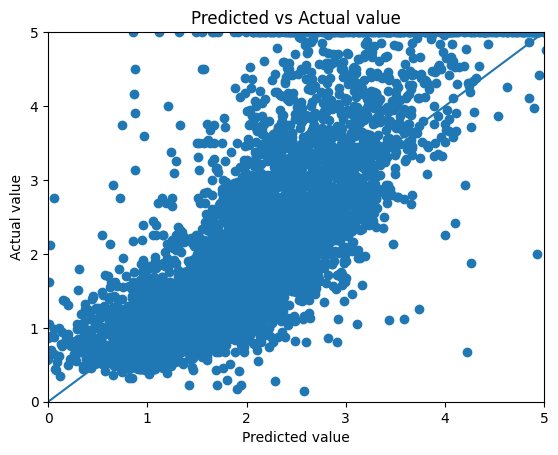

In [12]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs Actual value")
plt.xlim([0,5])
plt.ylim([0,5])
plt.scatter(y_pred, y_test)
plt.plot([0,5],[0,5])

In [13]:
def mae(preds: np.ndarray, actuals: np.ndarray):
    '''
    Compute mean absolute error.
    '''
    return np.mean(np.abs(preds - actuals))

def rmse(preds: np.ndarray, actuals: np.ndarray):
    '''
    Compute root mean squared error.
    '''
    return np.sqrt(np.mean(np.power(preds - actuals, 2)))

In [14]:
print("Mean absolute error:", round(mae(y_pred, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(y_pred, y_test), 4))

Mean absolute error: 0.5272 
Root mean squared error: 0.7284


In [15]:
lr.coef_ # weights obtained from linear regression

array([[ 8.46962874e-01,  1.21848755e-01, -3.02077128e-01,
         3.68977844e-01, -8.78475338e-04, -3.50004161e-02,
        -8.93952910e-01, -8.68886568e-01]])

In [16]:
lr.intercept_ # bias obtained from linear regression

array([2.06893709])

Manual regression using the forward loss and backprop gradients we coded up before

In [17]:
def permute_data(X: np.ndarray, y: np.ndarray):
    '''
    Permute X and y, using the same permutation, along axis=0
    '''
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]


In [18]:
Batch = Tuple[np.ndarray, np.ndarray]

def generate_batch(X: np.ndarray, 
                   y: np.ndarray,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    '''
    Generate batch from X and y, given a start position
    '''
    assert X.ndim == y.ndim == 2, \
    "X and Y must be 2 dimensional"

    if ((start+batch_size) > X.shape[0]):
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

In [19]:
def init_weights(n_in: int) -> Dict[str, np.ndarray]:
    '''
    Initialize weights on first forward pass of model.
    '''
    
    weights: Dict[str, np.ndarray] = {}
    W = np.random.randn(n_in, 1)
    B = np.random.randn(1, 1)
    
    weights['W'] = W
    weights['B'] = B

    return weights

In [20]:
def train(X: np.ndarray, 
          y: np.ndarray, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:
    '''
    Train model for a certain number of epochs.
    '''
    if seed:
        np.random.seed(seed)
    start = 0

    # Initialize weights
    weights = init_weights(X.shape[1])

    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        # Generate batch
        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        loss,forward_info = forward_linear_regression(X_batch, y_batch, weights)


        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]

    if return_weights:
        return losses, weights
    
    return None


    

In [21]:
	
train_info = train(X_train, y_train,
                   n_iter = 10000,
                   learning_rate = 0.0001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=180708)
losses = train_info[0]
weights = train_info[1]

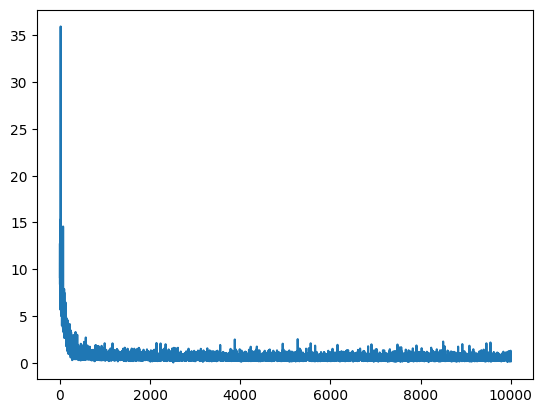

In [22]:
plt.plot(list(range(10000)), train_info[0])

In [23]:
def predict(X: np.ndarray,
            weights: Dict[str, np.ndarray]):
    '''
    Generate predictions from the step-by-step linear regression model.
    '''

    N = np.dot(X, weights['W'])

    return N + weights['B']

In [24]:
preds = predict(X_test, weights)

In [25]:
print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error: 0.5287 
Root mean squared error: 0.7298


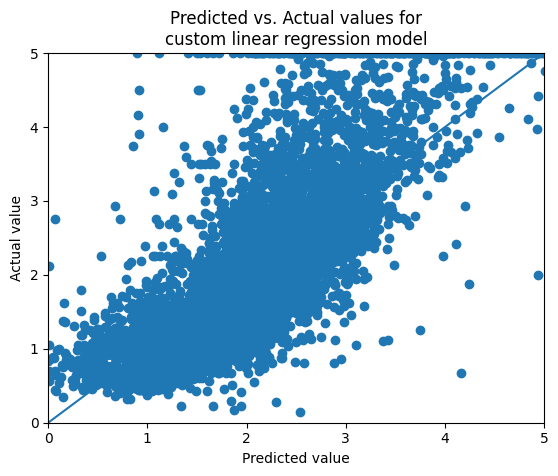

In [26]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\ncustom linear regression model");
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.scatter(preds, y_test)
plt.plot([0, 5], [0, 5]);
# plt.savefig(GRAPHS_IMG_FILEPATH + "01_linear_custom_pred_vs_actual.png");

In [27]:
#comparison of weights of manual regression and sklearn regression 
print(weights['W'])
print(lr.coef_)

[[ 0.82903694]
 [ 0.12585241]
 [-0.23669174]
 [ 0.32685348]
 [-0.00394049]
 [-0.0258485 ]
 [-0.89487045]
 [-0.86564055]]
[[ 8.46962874e-01  1.21848755e-01 -3.02077128e-01  3.68977844e-01
  -8.78475338e-04 -3.50004161e-02 -8.93952910e-01 -8.68886568e-01]]


In [28]:
print(weights['B'])
print(lr.intercept_)

[[2.07608342]]
[2.06893709]


Neural networks from scratch

In [29]:
def sigmoid(x : np.ndarray) -> np.ndarray:
    return 1 / (1+np.exp(-x))

In [32]:
def forward_loss(X : np.ndarray, y : np.ndarray, weights : Dict[str,np.ndarray]) -> Tuple[Dict[str,np.ndarray], float] :
    M1 = np.dot(X, weights['W1'])
    N1 = M1 + weights['B1']
    O1 = sigmoid(N1)
    M2 = np.dot(O1, weights['W2'])
    P = M2 + weights['B2']
    loss = np.mean(np.power(y-P,2))
    forward_info : Dict[str,np.ndarray] = {}
    forward_info['X'] = X
    forward_info['y'] = y
    forward_info['M1'] = M1
    forward_info['N1'] = N1
    forward_info['O1'] = O1
    forward_info['M2'] = M2
    forward_info['P'] = P
    return forward_info,loss

    


In [34]:
def loss_gradients(forward_info : Dict[str,np.ndarray],weights : Dict[str,np.ndarray]) -> Dict[str,np.ndarray] :
    dLdP = -2 * (forward_info['y'] - forward_info['P'])
    dPdM2 = np.ones_like(forward_info['M2'])
    dPdB2 = np.ones_like(weights['B2'])
    dLdM2 = dLdP * dPdM2
    dLdB2 = (dLdP * dPdB2).sum(axis=0)
    dM2dO1 = np.transpose(weights['W2'],(1,0))
    dM2dW2 = np.transpose(forward_info['O1'],(1,0))
    dLdW2 = np.dot(dM2dW2,dLdM2)
    dLdO1 = np.dot( dLdM2,dM2dO1)
    dO1dN1 = sigmoid(forward_info['N1']) * (1 - sigmoid(forward_info['N1']))
    dLdN1 = dLdO1 * dO1dN1
    dN1dB1 = np.ones_like(weights['B1'])
    dN1dM1 = np.ones_like(forward_info['M1'])
    dLdB1 = (dLdN1 * dN1dB1).sum(axis=0)
    dLdM1 = dLdN1 * dN1dM1
    dM1dW1 = np.transpose(forward_info['X'],(1,0))
    dLdW1 = np.dot(dM1dW1,dLdM1)
    loss_gradients : Dict[str,np.ndarray] = {}
    loss_gradients['W1'] = dLdW1
    loss_gradients['B1'] = dLdB1.sum(axis=0)
    loss_gradients['W2'] = dLdW2
    loss_gradients['B2'] = dLdB2.sum(axis=0)
















In [35]:
def init_weights(input_size : int, hidden_size : int) -> Dict[str,np.ndarray]:
    weights : Dict[str,np.ndarray] = {}
    weights['W1'] = np.random.randn(input_size, hidden_size)
    weights['B1'] = np.random.randn(1,hidden_size)
    weights['W2'] = np.random.randn(hidden_size,1)
    weights['B2'] = np.random_randn(1,1)
    return weights

In [36]:
def predict(X : np.ndarray, weights : Dict[str, np.ndarray]) -> np.ndarray:
    M1 = np.dot(X, weights['W1'])
    N1 = M1 + weights['B1']
    O1 = sigmoid(N1)
    M2 = np.dot(O1,weights['W2'])
    P = M2 + weights['B2']
    return P

In [ ]:
def train(X_train : np.ndarray, y_train : np.ndarray, X_test : np.ndarray, y_test : np.ndarray,
          n_iter : int = 1000, learning_rate : float = 0.001, hidden_size : int = 13, 
          batch_size : int = 13, return_losses : bool = False, return_weights : bool = False, return_scores : bool = False, 
          seed : int = 42) -> None :
    if seed:
        np.random.seed(seed)
    start = 0
    #init weights
    weights = init_weights(X_train.shape[1], hidden_size)
    X_train, y_train = permute_data(X_train, y_train) # shuffle input data
    losses = []
    val_scores = []
    
    for i in range(n_iter):
        # generate batch
        if start >= X_train.shape[0]:
            X_train, y_train = permute_data(X_train, y_train)
            start = 0
        X_batch, y_batch = generate_batch(X_train, y_train, start, batch_size)
        start += batch_size

        #forward_pass
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)
        
        # backprop
        loss_grads = loss_gradients(forward_info, weights)
        
        #update weights
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
        
        if return_scores:
            y_pred = predict(X_test, weights)
            val_scores.append()







